# Image Processing for Remote Sensing Homework II

## **1. Introduction**

The goal of this homework is to use a ResNet18 architecture for supervised scene classification on multi-label remote sensing images. During experiments different data augmentation techniques have to be investigated.

## **2. Dataset**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm.notebook import tqdm
from pathlib import Path
import zipfile
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

In [2]:
def download_file_with_progress(url: str, output_file: Path):
    """
    method from lab07
    --------------------
    Given a `url` as a String and an `output_file` as a file-path the item will
    be downloaded and written to the `output_file`. If the `output_file` already
    exists, it will be overwritten.
    """
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))
    chunk_size = 2**20  # mb

    with open(output_file, "wb") as f:
        for data in tqdm(
            response.iter_content(chunk_size=chunk_size),
            total=total_size // chunk_size,
            unit="MB",
            unit_scale=True,
            desc="Downloading",
        ):
            f.write(data)

In [3]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)

#### subtask: implement the instance method read_multilabels(self) of the UCMerced Dataset class

In [4]:
import pandas as pd    # read multi-label

In [5]:
class UCMerced(Dataset):
    """
    UCMerced class from lab07, add "read_multilabels" method
    -------------
    parse labels for each image, using LandUse_Multilabeled.xlsx
    """
    def __init__(self, base_dir: Path, img_transform: transforms = None, multilabel: bool = False):
        self.base_dir = base_dir
        self.download_dataset()
        self.images_path = base_dir / "UCMerced_LandUse/Images"
        self.class_names = sorted(
            [cl.name for cl in self.images_path.iterdir() if not cl.name.startswith(".")]
        )
        self.img_paths, self.targets = self.read_data()
        self.img_transform = img_transform

        if multilabel:
            self.targets, self.class_names = self.read_multilabels()  # important for loss calculation
            self.targets = self.targets.astype(float)
            
    def download_dataset(self):
        ucmerced_path = self.base_dir / "UCMerced.zip"
        if not ucmerced_path.exists():
            print("Downloading UCMerced")
            download_file_with_progress(
                "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip",
                ucmerced_path,
            )
            zipf = zipfile.ZipFile(ucmerced_path)
            zipf.extractall(self.base_dir)

    def read_data(self):
        img_paths, targets = [], []
        for cl_id, cl_name in enumerate(self.class_names):
            cl_path = self.images_path / cl_name

            for img_path in sorted(cl_path.iterdir()):
                img_paths.append(img_path)
                targets.append(cl_id)

        return img_paths, targets

    def read_multilabels(self):
        multilabel_path = self.base_dir / "UCMerced_LandUse/multilabels/LandUse_Multilabeled.xlsx"
        df = pd.read_excel(multilabel_path)    # use pandas to parse .xlsx
        classes = df.columns[1:].tolist()
        df.set_index('IMAGE\LABEL', inplace=True)   # set the index in .xlsx
        
        multilabel_targets = []
        for img_path in self.img_paths:
            img_name = img_path.stem  # get file name (same in the .xlsx index)
            multilabel_targets.append(df.loc[img_name].values)
        return np.array(multilabel_targets), classes
    
    def __getitem__(self, idx: int):
        img_path = self.img_paths[idx]
        target = self.targets[idx]

        img = Image.open(img_path).convert("RGB")
        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return len(self.img_paths)

In [6]:
full_dataset = UCMerced(data_path, multilabel=True)
full_dataset

#### subtask: provide a statistical analysis of the class distribution of the multi-label version. 
Instead of 21 classes, 17 classes appear in the multi-label file. Classes are stored in UCMerced.classes.

,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
distribution,100.0000,718.0000,691.0000,886.0000,115.0000,105.000,100.0000,103.0000,975.0000,102.0000,1300.0000,294.000,100.0000,102.0000,100.0000,1009.0000,203.000
ratio,0.0143,0.1025,0.0987,0.1265,0.0164,0.015,0.0143,0.0147,0.1392,0.0146,0.1856,0.042,0.0143,0.0146,0.0143,0.1441,0.029
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,1.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,1.0000,0.000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,1.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,1.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,1.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,1.0000,0.000


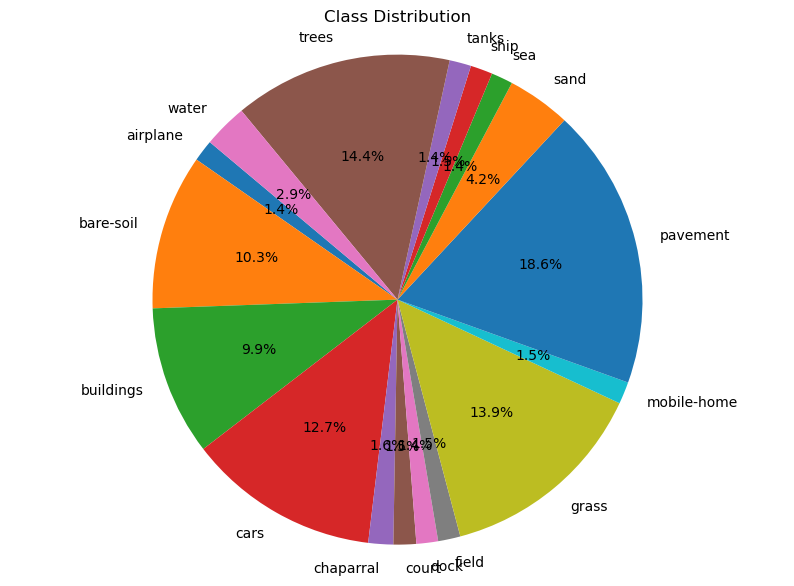

In [7]:
def analyze_class_distribution(targets, classes):
    df = pd.DataFrame(targets)
    class_distribution = df.sum(axis=0).apply(int)  # .Series
    total = class_distribution.sum()
    cd_ratio = (class_distribution / total).round(4)
    
    cd_df = pd.DataFrame([class_distribution, cd_ratio], index=['distribution', 'ratio'])
    df = pd.concat([cd_df, df], ignore_index=False)
    df.loc[0] = df.loc[0].astype(int)
    df.columns = classes[:len(classes)]    # set column indices
    display(df.head(7))
    
    plt.figure(figsize=(10, 7))
    plt.pie(class_distribution, labels=classes[:len(class_distribution)], autopct='%1.1f%%', startangle=140)
    plt.title('Class Distribution')
    plt.axis('equal') 
    
class_distribution = analyze_class_distribution(full_dataset.targets, full_dataset.class_names)

## **3. Training Design**

#### subtask: split dataset (baseline)

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

def get_split_idx(targets: np.array, train_size: float, val_size: float, test_size: float):
    """
    'splitting method' from lab07
    adjusted for multilabel classification task with random selection
    ----------------
    stratified sampling fails, cause: some classes have too few samples
    """
    assert train_size + val_size + test_size == 1
    
    # Initial split to separate test set
    full_idx = np.arange(len(targets))
    train_val_idx, test_idx = train_test_split(
        full_idx, test_size=test_size, random_state=42
    )
    
    # Adjust sizes for train and validation splits
    relative_val_size = val_size / (train_size + val_size)
    train_idx, val_idx = train_test_split(
        train_val_idx, test_size=relative_val_size, random_state=42
    )
    
    return train_idx, val_idx, test_idx

# splitting ratio
train_size = 0.7
val_size = 0.1
test_size = 0.2
train_idx, val_idx, test_idx = get_split_idx(full_dataset.targets, train_size, val_size, test_size)

print(f'train_len: {len(train_idx):4} ({len(train_idx)/len(full_dataset.targets)*100:.2f}%)')
print(f'val_len:   {len(val_idx):4} ({len(val_idx)/len(full_dataset.targets)*100:.2f}%)')
print(f'test_len:  {len(test_idx):4} ({len(test_idx)/len(full_dataset.targets)*100:.2f}%)')

train_len: 1469 (69.95%)
val_len:    211 (10.05%)
test_len:   420 (20.00%)


In [10]:
"""
apply baseline transformations
"""
ucm_mean = [0.595425, 0.3518577, 0.3225522]  
ucm_std = [0.19303136, 0.12492529, 0.10577361]
tr_transform_base = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)
te_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)


In [11]:
# apply test set for all experiments
batch_size     = 64
full_dataset_te = UCMerced(data_path, img_transform=te_transform, multilabel=True)

val_dataset = Subset(full_dataset_te, val_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = Subset(full_dataset_te, test_idx)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
def get_split_transform_train_data(tr_transform):
    # get full dataset
    full_dataset_tr = UCMerced(data_path, img_transform=tr_transform, multilabel=True)
    train_dataset = Subset(full_dataset_tr, train_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_dataset, train_loader

#### subtask:  apply transfer learning, choose a pre-trained ResNet18 

In [13]:
from torchvision import models
from torchvision.models import ResNet18_Weights
import torch.optim as optim
import torch.nn as nn
import torch
import copy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  f1_score, average_precision_score
from typing import List

In [14]:
def train(
    model: nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss,
    train_loader: DataLoader,
    epochs: int,
    device: torch.device,
    val_loader: DataLoader = None,
):
    """
    Training loop to optimize a network for several epochs and a specified loss.

    Args:
    -----
    model               : a PyTorch model
    optimizer           : a PyTorch optimizer
    criterion           : a PyTorch-compatible loss function, e.g. nn.CrossEntropyLoss
    train_loader        : a PyTorch trainset loader
    epochs              : int specifying the number of training epochs
    device              : torch device to use (defaults to CPU)
    val_loader (opt.)   : validation dataset
    """
    model.to(device)  # put model on device
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_model = copy.deepcopy(model)
    best_acc = 0
    best_epoch = 1

    for epoch in tqdm(range(1, epochs + 1), desc="Training the network"):
        model.train()  # set model to training mode
        train_losses_epoch = []
        train_targets = []
        train_preds = []

        # Data-Loading Loop
        with tqdm(train_loader, unit=" batch") as tepoch:
            for idx, (data, targets) in enumerate(tepoch):
                tepoch.set_description("Epoch {}".format(epoch))

                # put loaded data and targets on device
                data, targets = data.to(device), targets.to(device)

                # zero accumulated gradients from previous batch
                optimizer.zero_grad()

                # infer predictions for batch
                output = model(data)
                predictions = (output > 0.5).float() # transformed individually into probabilities, threshold of 0.5
                
                # compute loss from predictions, CELoss automatically applies F.log_softmax
                loss = criterion(output, targets)

                # accumulate gradients for all parameter according to batch errors
                loss.backward()

                # update paramters according to accumulated gradients
                optimizer.step()

                train_losses_epoch.append(loss.item())
                train_targets.append(targets)
                train_preds.append(predictions)
            
            curr_train_loss = np.mean(train_losses_epoch)
            train_targets = torch.cat(train_targets)
            train_preds = torch.cat(train_preds)

            train_accuracy = accuracy_score(train_targets, train_preds)
            train_losses.append(curr_train_loss)
            train_accuracies.append(train_accuracy)
            
            print("Train-Loss: {:.2f}. Train-Acc: {:.2f}".format(curr_train_loss, train_accuracy))

        if val_loader is not None:
            model.eval()
            val_losses_epoch = []
            val_targets = []
            val_preds = []

            with torch.no_grad():
                for data, targets in val_loader:
                    # put loaded data and targets on device
                    data = data.to(device)
                    targets = targets.to(device).float()
                    
                    output = model(data)
                    loss = criterion(output, targets)
                    predictions = (output > 0.5).float()
    
                    val_losses_epoch.append(loss.item())
                    val_targets.append(targets)
                    val_preds.append(predictions)
            
            curr_val_loss = np.mean(val_losses_epoch)
            val_targets = torch.cat(val_targets)
            val_preds = torch.cat(val_preds)
            
            val_accuracy = accuracy_score(val_targets, val_preds)
            val_losses.append(curr_val_loss)
            val_accuracies.append(val_accuracy)
            
            # early stopping
            if best_acc < val_accuracy:
                best_acc = val_accuracy
                best_epoch = epoch
                best_model = copy.deepcopy(model)

            if epoch - best_epoch > 10:
                print(f"Early stopping after {epoch} epochs with best epoch in {best_epoch}")
                break
            
            print("Val-Loss:   {:.2f}. Val-Acc:   {:.2f}".format(curr_val_loss, val_accuracy))
    
    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

In [15]:
def test(
    model: nn.Module,
    test_loader: DataLoader,
    class_names: list,
    device: torch.device,
):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(test_loader, desc="Test: ")):
            # put loaded data and targets on device
            data = data.to(device)
            target = target.to(device)
            
            output = model(data)
            predicted = (output > 0.5).float()
            predictions += predicted.tolist()
            targets += target.tolist()

    results = {}

    if class_names is None:
        class_names = range(len(np.unique(targets)))

#     cm = confusion_matrix(targets, predictions)
#     results["cm"] = cm
    results["overall_acc"] = accuracy_score(targets, predictions)
    results["f1_micro"] = f1_score(targets, predictions, average='micro')
    results["f1_macro"] = f1_score(targets, predictions, average='macro')
    results["mAP_micro"] = average_precision_score(targets, predictions, average='micro')
    results["mAP_macro"] = average_precision_score(targets, predictions, average='macro')
    
    results["report"] = classification_report(
        targets,
        predictions,
        target_names=class_names,
        zero_division=0,
        digits=2,
    )

    return results

In [16]:
def show_results(results):
    print("overall_acc\t", results["overall_acc"])
    print("f1_micro\t", results["f1_micro"])
    print("f1_macro\t", results["f1_macro"])
    print("mAP_micro\t", results["mAP_micro"])
    print("mAP_macro\t", results["mAP_macro"])
    print(results['report'])

## 4. Experiments

In [17]:
from matplotlib.ticker import MaxNLocator

def get_device(cuda_no):
    return torch.device('cpu') if cuda_no < 0 or not torch.cuda.is_available() else torch.device(cuda_no)

device         = get_device(-1)   # cuda doesn't work
learning_rate  = 0.01
epochs         = 60
momentum       = 0.9
criterion = nn.BCEWithLogitsLoss()

In [18]:
import json

def save_results_to_json(results, filename):
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)

def load_results_from_json(filename):
    with open(filename, 'r') as f:
        results = json.load(f)
    return results

results_path = Path("./results0")
results_path.mkdir(exist_ok=True)

#### 4.1 A baseline that does not contain any data augmentation

In [19]:
tr_transform_base = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

train_dataset_base, train_loader_base = get_split_transform_train_data(tr_transform_base)

In [20]:
resnet_pretrained1 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained1.fc = nn.Linear(512, 17)

optimizer = optim.SGD(
    resnet_pretrained1.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=0.0001,
    nesterov=True,
)

In [21]:
best_model1, train_losses1, val_losses1, train_accuracies1, val_accuracies1 = train(
    model=resnet_pretrained1,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_base,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.44. Train-Acc: 0.03
Val-Loss:   0.33. Val-Acc:   0.09


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.25. Train-Acc: 0.13
Val-Loss:   0.26. Val-Acc:   0.17


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.19. Train-Acc: 0.28
Val-Loss:   0.23. Val-Acc:   0.23


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.15. Train-Acc: 0.40
Val-Loss:   0.21. Val-Acc:   0.30


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.12. Train-Acc: 0.48
Val-Loss:   0.20. Val-Acc:   0.31


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.10. Train-Acc: 0.57
Val-Loss:   0.19. Val-Acc:   0.33


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.09. Train-Acc: 0.64
Val-Loss:   0.19. Val-Acc:   0.35


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.69
Val-Loss:   0.19. Val-Acc:   0.35


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.74
Val-Loss:   0.19. Val-Acc:   0.35


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.80
Val-Loss:   0.19. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.83
Val-Loss:   0.19. Val-Acc:   0.37


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.86
Val-Loss:   0.19. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.87
Val-Loss:   0.19. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.03. Train-Acc: 0.90
Val-Loss:   0.19. Val-Acc:   0.37


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.03. Train-Acc: 0.92
Val-Loss:   0.19. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.03. Train-Acc: 0.94
Val-Loss:   0.20. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.02. Train-Acc: 0.93
Val-Loss:   0.20. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.02. Train-Acc: 0.94
Val-Loss:   0.20. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.02. Train-Acc: 0.95
Val-Loss:   0.20. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.02. Train-Acc: 0.96
Val-Loss:   0.20. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.02. Train-Acc: 0.96
Val-Loss:   0.20. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.02. Train-Acc: 0.98
Val-Loss:   0.20. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.02. Train-Acc: 0.98
Val-Loss:   0.21. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.98
Val-Loss:   0.21. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.97
Val-Loss:   0.20. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.98
Val-Loss:   0.21. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Val-Loss:   0.21. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Val-Loss:   0.21. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Val-Loss:   0.21. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Val-Loss:   0.21. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Val-Loss:   0.21. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Val-Loss:   0.21. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Val-Loss:   0.21. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 1.00
Val-Loss:   0.21. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Val-Loss:   0.22. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.01. Train-Acc: 0.99
Early stopping after 36 epochs with best epoch in 25


In [22]:
results1 = test(best_model1, test_loader, full_dataset_te.class_names, device)

Test:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
show_results(results1)

overall_acc	 0.4023809523809524
f1_micro	 0.8186646433990895
f1_macro	 0.8080345210017872
mAP_micro	 0.7173680285623508
mAP_macro	 0.73430816161051
              precision    recall  f1-score   support

    airplane       0.91      0.59      0.71        17
   bare-soil       0.79      0.61      0.69       140
   buildings       0.80      0.83      0.81       127
        cars       0.84      0.76      0.80       181
   chaparral       1.00      0.93      0.96        27
       court       0.75      0.26      0.39        23
        dock       1.00      0.95      0.97        20
       field       1.00      0.95      0.98        21
       grass       0.91      0.72      0.80       202
 mobile-home       0.95      0.67      0.78        27
    pavement       0.90      0.91      0.91       258
        sand       0.85      0.57      0.68        58
         sea       1.00      1.00      1.00        20
        ship       1.00      0.95      0.97        20
       tanks       1.00      0.44      0.

In [26]:
file_name = results_path / f"val_accuracies1.json"
save_results_to_json(val_accuracies1, file_name)

#### 4.2 A method that includes random affine transformation (e.g. degrees=10) and random auto-contrast

In [19]:
tr_transform_affine_autocontrast = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomAffine(degrees=10),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

train_dataset_aa, train_loader_aa = get_split_transform_train_data(tr_transform_affine_autocontrast)

In [20]:
resnet_pretrained2 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained2.fc = nn.Linear(512, 17)

optimizer = optim.SGD(
    resnet_pretrained2.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=0.0001,
    nesterov=True,
)

In [21]:
best_model2, train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train(
    model=resnet_pretrained2,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_aa,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.45. Train-Acc: 0.02
Val-Loss:   0.34. Val-Acc:   0.07


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.29. Train-Acc: 0.07
Val-Loss:   0.28. Val-Acc:   0.11


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.23. Train-Acc: 0.17
Val-Loss:   0.24. Val-Acc:   0.22


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.19. Train-Acc: 0.27
Val-Loss:   0.22. Val-Acc:   0.29


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.16. Train-Acc: 0.35
Val-Loss:   0.20. Val-Acc:   0.31


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.15. Train-Acc: 0.39
Val-Loss:   0.19. Val-Acc:   0.33


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.13. Train-Acc: 0.43
Val-Loss:   0.19. Val-Acc:   0.33


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.12. Train-Acc: 0.47
Val-Loss:   0.18. Val-Acc:   0.35


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.11. Train-Acc: 0.49
Val-Loss:   0.18. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.11. Train-Acc: 0.52
Val-Loss:   0.18. Val-Acc:   0.35


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.10. Train-Acc: 0.57
Val-Loss:   0.17. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.09. Train-Acc: 0.58
Val-Loss:   0.17. Val-Acc:   0.37


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.61
Val-Loss:   0.17. Val-Acc:   0.37


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.63
Val-Loss:   0.17. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.64
Val-Loss:   0.17. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.69
Val-Loss:   0.17. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.69
Val-Loss:   0.17. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.72
Val-Loss:   0.17. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.75
Val-Loss:   0.17. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.75
Val-Loss:   0.18. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.77
Val-Loss:   0.18. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.79
Val-Loss:   0.18. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.80
Val-Loss:   0.18. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.83
Val-Loss:   0.18. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.84
Val-Loss:   0.18. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.03. Train-Acc: 0.86
Early stopping after 26 epochs with best epoch in 15


In [22]:
results2 = test(best_model2, test_loader, full_dataset_te.class_names, device)

Test:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
show_results(results2)

overall_acc	 0.42857142857142855
f1_micro	 0.8341555977229601
f1_macro	 0.8429539994670496
mAP_micro	 0.7402997201114841
mAP_macro	 0.7744065396348563
              precision    recall  f1-score   support

    airplane       0.93      0.82      0.87        17
   bare-soil       0.84      0.66      0.74       140
   buildings       0.85      0.76      0.80       127
        cars       0.87      0.79      0.83       181
   chaparral       1.00      0.93      0.96        27
       court       1.00      0.43      0.61        23
        dock       1.00      1.00      1.00        20
       field       1.00      0.95      0.98        21
       grass       0.88      0.79      0.83       202
 mobile-home       1.00      0.70      0.83        27
    pavement       0.90      0.91      0.91       258
        sand       0.92      0.62      0.74        58
         sea       0.94      0.85      0.89        20
        ship       1.00      1.00      1.00        20
       tanks       0.91      0.56     

In [25]:
file_name = results_path / f"val_accuracies2.json"
save_results_to_json(val_accuracies2, file_name)

#### 4.3 A method that consists of 3 augmentation methods that you select on your own
* random horizontal flip
* random rotation
* random brightness adjustment

In [20]:
tr_transform_combined = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)
train_dataset_c, train_loader_c = get_split_transform_train_data(tr_transform_combined)

In [21]:
resnet_pretrained3 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained3.fc = nn.Linear(512, 17)

optimizer = optim.SGD(
    resnet_pretrained3.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=0.0001,
    nesterov=True,
)

In [22]:
best_model3, train_losses3, val_losses3, train_accuracies3, val_accuracies3 = train(
    model=resnet_pretrained3,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_c,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.43. Train-Acc: 0.02
Val-Loss:   0.34. Val-Acc:   0.05


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.29. Train-Acc: 0.07
Val-Loss:   0.28. Val-Acc:   0.14


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.24. Train-Acc: 0.18
Val-Loss:   0.24. Val-Acc:   0.21


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.20. Train-Acc: 0.24
Val-Loss:   0.21. Val-Acc:   0.27


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.18. Train-Acc: 0.31
Val-Loss:   0.20. Val-Acc:   0.29


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.17. Train-Acc: 0.35
Val-Loss:   0.19. Val-Acc:   0.32


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.15. Train-Acc: 0.38
Val-Loss:   0.18. Val-Acc:   0.34


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.14. Train-Acc: 0.40
Val-Loss:   0.17. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.13. Train-Acc: 0.43
Val-Loss:   0.17. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.13. Train-Acc: 0.46
Val-Loss:   0.16. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.12. Train-Acc: 0.48
Val-Loss:   0.16. Val-Acc:   0.37


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.11. Train-Acc: 0.49
Val-Loss:   0.16. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.11. Train-Acc: 0.50
Val-Loss:   0.15. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.10. Train-Acc: 0.52
Val-Loss:   0.15. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.10. Train-Acc: 0.56
Val-Loss:   0.15. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.09. Train-Acc: 0.56
Val-Loss:   0.15. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.09. Train-Acc: 0.58
Val-Loss:   0.15. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.09. Train-Acc: 0.59
Val-Loss:   0.15. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.59
Val-Loss:   0.15. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.61
Val-Loss:   0.15. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.61
Val-Loss:   0.15. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.64
Val-Loss:   0.15. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.67
Val-Loss:   0.15. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.66
Val-Loss:   0.15. Val-Acc:   0.44


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.68
Val-Loss:   0.16. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.69
Val-Loss:   0.16. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.72
Val-Loss:   0.16. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.72
Val-Loss:   0.16. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.73
Val-Loss:   0.16. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.72
Val-Loss:   0.16. Val-Acc:   0.44


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.76
Val-Loss:   0.16. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.75
Val-Loss:   0.16. Val-Acc:   0.44


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.79
Val-Loss:   0.16. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.77
Val-Loss:   0.16. Val-Acc:   0.44


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.79
Early stopping after 35 epochs with best epoch in 24


In [23]:
results3 = test(best_model3, test_loader, full_dataset_te.class_names, device)

Test:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
show_results(results3)

overall_acc	 0.44285714285714284
f1_micro	 0.8500563697857948
f1_macro	 0.8705836526758488
mAP_micro	 0.7618554189742935
mAP_macro	 0.8129598403408764
              precision    recall  f1-score   support

    airplane       0.94      0.88      0.91        17
   bare-soil       0.81      0.66      0.73       140
   buildings       0.93      0.83      0.88       127
        cars       0.86      0.77      0.81       181
   chaparral       1.00      0.96      0.98        27
       court       1.00      0.48      0.65        23
        dock       1.00      1.00      1.00        20
       field       1.00      0.90      0.95        21
       grass       0.86      0.75      0.80       202
 mobile-home       1.00      0.81      0.90        27
    pavement       0.92      0.90      0.91       258
        sand       0.91      0.69      0.78        58
         sea       1.00      0.95      0.97        20
        ship       1.00      1.00      1.00        20
       tanks       1.00      0.61     

In [26]:
file_name = results_path / f"val_accuracies3.json"
save_results_to_json(val_accuracies3, file_name)

#### 4.4 A method that includes the composed data augmentation technique RandAugment 

In [19]:
from torchvision.transforms import RandAugment

tr_transform_randaugment = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

train_dataset_r, train_loader_r = get_split_transform_train_data(tr_transform_randaugment)

In [20]:
resnet_pretrained4 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_pretrained4.fc = nn.Linear(512, 17)

optimizer = optim.SGD(
    resnet_pretrained4.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=0.0001,
    nesterov=True,
)

best_model4, train_losses4, val_losses4, train_accuracies4, val_accuracies4 = train(
    model=resnet_pretrained4,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_r,
    epochs=epochs,
    device=device,
    val_loader=val_loader,
)

Training the network:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.43. Train-Acc: 0.02
Val-Loss:   0.34. Val-Acc:   0.08


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.31. Train-Acc: 0.07
Val-Loss:   0.27. Val-Acc:   0.15


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.25. Train-Acc: 0.14
Val-Loss:   0.23. Val-Acc:   0.26


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.22. Train-Acc: 0.20
Val-Loss:   0.20. Val-Acc:   0.30


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.19. Train-Acc: 0.27
Val-Loss:   0.19. Val-Acc:   0.34


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.17. Train-Acc: 0.31
Val-Loss:   0.18. Val-Acc:   0.32


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.16. Train-Acc: 0.35
Val-Loss:   0.18. Val-Acc:   0.35


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.15. Train-Acc: 0.37
Val-Loss:   0.17. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.14. Train-Acc: 0.41
Val-Loss:   0.17. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.13. Train-Acc: 0.42
Val-Loss:   0.16. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.13. Train-Acc: 0.44
Val-Loss:   0.16. Val-Acc:   0.35


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.12. Train-Acc: 0.46
Val-Loss:   0.16. Val-Acc:   0.36


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.12. Train-Acc: 0.49
Val-Loss:   0.16. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.11. Train-Acc: 0.51
Val-Loss:   0.16. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.11. Train-Acc: 0.52
Val-Loss:   0.16. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.11. Train-Acc: 0.53
Val-Loss:   0.16. Val-Acc:   0.39


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.10. Train-Acc: 0.54
Val-Loss:   0.16. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.10. Train-Acc: 0.55
Val-Loss:   0.16. Val-Acc:   0.38


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.09. Train-Acc: 0.59
Val-Loss:   0.16. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.09. Train-Acc: 0.59
Val-Loss:   0.16. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.61
Val-Loss:   0.16. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.61
Val-Loss:   0.16. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.08. Train-Acc: 0.63
Val-Loss:   0.16. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.66
Val-Loss:   0.16. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.66
Val-Loss:   0.16. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.69
Val-Loss:   0.16. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.07. Train-Acc: 0.67
Val-Loss:   0.16. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.72
Val-Loss:   0.16. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.70
Val-Loss:   0.16. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.71
Val-Loss:   0.17. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.73
Val-Loss:   0.16. Val-Acc:   0.44


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.06. Train-Acc: 0.71
Val-Loss:   0.16. Val-Acc:   0.44


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.73
Val-Loss:   0.17. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.75
Val-Loss:   0.16. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.78
Val-Loss:   0.17. Val-Acc:   0.40


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.05. Train-Acc: 0.78
Val-Loss:   0.17. Val-Acc:   0.41


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.79
Val-Loss:   0.17. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.79
Val-Loss:   0.17. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.77
Val-Loss:   0.17. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.81
Val-Loss:   0.18. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.81
Val-Loss:   0.17. Val-Acc:   0.42


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.83
Val-Loss:   0.17. Val-Acc:   0.43


  0%|          | 0/23 [00:00<?, ? batch/s]

Train-Loss: 0.04. Train-Acc: 0.81
Early stopping after 43 epochs with best epoch in 32


In [21]:
results4 = test(best_model4, test_loader, full_dataset_te.class_names, device)

Test:   0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
show_results(results4)

overall_acc	 0.45714285714285713
f1_micro	 0.8525807649461566
f1_macro	 0.8647708577173329
mAP_micro	 0.7629728657499423
mAP_macro	 0.7997387482268845
              precision    recall  f1-score   support

    airplane       0.93      0.82      0.87        17
   bare-soil       0.80      0.69      0.74       140
   buildings       0.85      0.85      0.85       127
        cars       0.87      0.83      0.85       181
   chaparral       1.00      0.96      0.98        27
       court       1.00      0.48      0.65        23
        dock       1.00      1.00      1.00        20
       field       1.00      0.95      0.98        21
       grass       0.85      0.78      0.81       202
 mobile-home       0.96      0.81      0.88        27
    pavement       0.93      0.92      0.92       258
        sand       0.93      0.67      0.78        58
         sea       1.00      0.90      0.95        20
        ship       1.00      1.00      1.00        20
       tanks       0.92      0.61     

In [24]:
file_name = results_path / f"val_accuracies4.json"
save_results_to_json(val_accuracies4, file_name)

#### Summary

In [25]:
file_name = results_path / f"val_accuracies1.json"
val_accu1 = load_results_from_json(file_name)
file_name = results_path / f"val_accuracies2.json"
val_accu2 = load_results_from_json(file_name)
file_name = results_path / f"val_accuracies3.json"
val_accu3 = load_results_from_json(file_name)
file_name = results_path / f"val_accuracies4.json"
val_accu4 = load_results_from_json(file_name)

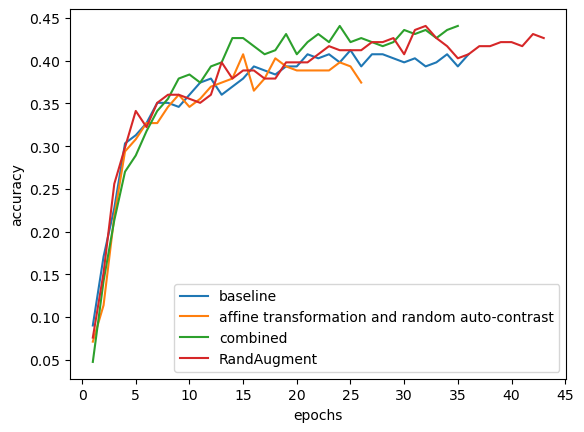

In [27]:
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(
    np.arange(1, len(val_accu1) + 1), val_accu1, label="baseline"
)
ax.plot(
    np.arange(1, len(val_accu2) + 1), val_accu2, label="affine transformation and random auto-contrast"
)
ax.plot(
    np.arange(1, len(val_accu3) + 1), val_accu3, label="combined"
)
ax.plot(
    np.arange(1, len(val_accu4) + 1), val_accu4, label="RandAugment"
)
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
ax.legend()

#### Analysis

In conclusion, the results are not so good. As the training in lab07, ResNet18 on multi-class classification tasks has the validation accuracy above 90%, but here showing a validation accuracies below 50%. To compare different methods:
* Baseline(without data augmentation): has the most rapid initial growth and exhibits stable performance.
* Affine Transformation and Random Auto-contrast: has fast initial growth and shows a trend similar to the baseline. The early stop is at 18th eppoch which has the fastest convergence.
* Combined Augmentation: the overall accuracy is slightly higher than both baseline and affine transformation methods.
* RandAugment: has slow initial growth, lagging behind other strategies and the performance improves in later stages. 
<br><br>
Overall, the combined augmentation method demonstrated the best performance in terms of validation accuracy.

In [42]:
f1_score1_d = dict(zip(full_dataset_te.class_names, f1_score1))
f1_score1_ds = dict(sorted(combined_dict.items(), key=lambda item: item[1], reverse=True))

In [74]:
f1_score1 = [0.71, 0.69, 0.81, 0.80, 0.96, 0.39, 0.97, 0.98, 0.80, 0.78, 0.91, 0.68, 1.00, 0.97, 0.62, 0.83, 0.84]
f1_score2 = [0.87, 0.74, 0.80, 0.83, 0.96, 0.61, 1.00, 0.98, 0.83, 0.83, 0.91, 0.74, 0.89, 1.00, 0.69, 0.80, 0.85]
f1_score3 = [0.91, 0.73, 0.88, 0.81, 0.98, 0.65, 1.00, 0.95, 0.80, 0.90, 0.91, 0.78, 0.97, 1.00, 0.76, 0.86, 0.91]
f1_score4 = [0.87, 0.74, 0.85, 0.85, 0.98, 0.65, 1.00, 0.98, 0.81, 0.88, 0.92, 0.78, 0.95, 1.00, 0.73, 0.85, 0.86]
f1 = [f1_score1, f1_score2, f1_score3, f1_score4]
for ind, val in enumerate(f1):
    f1_dict = dict(zip(full_dataset_te.class_names, val))
    f1_sorted = dict(sorted(f1_dict.items(), key=lambda item: item[1], reverse=True))
    display(f1_sorted)

{'sea': 1.0,
 'field': 0.98,
 'dock': 0.97,
 'ship': 0.97,
 'chaparral': 0.96,
 'pavement': 0.91,
 'water': 0.84,
 'trees': 0.83,
 'buildings': 0.81,
 'cars': 0.8,
 'grass': 0.8,
 'mobile-home': 0.78,
 'airplane': 0.71,
 'bare-soil': 0.69,
 'sand': 0.68,
 'tanks': 0.62,
 'court': 0.39}

{'dock': 1.0,
 'ship': 1.0,
 'field': 0.98,
 'chaparral': 0.96,
 'pavement': 0.91,
 'sea': 0.89,
 'airplane': 0.87,
 'water': 0.85,
 'cars': 0.83,
 'grass': 0.83,
 'mobile-home': 0.83,
 'buildings': 0.8,
 'trees': 0.8,
 'bare-soil': 0.74,
 'sand': 0.74,
 'tanks': 0.69,
 'court': 0.61}

{'dock': 1.0,
 'ship': 1.0,
 'chaparral': 0.98,
 'sea': 0.97,
 'field': 0.95,
 'airplane': 0.91,
 'pavement': 0.91,
 'water': 0.91,
 'mobile-home': 0.9,
 'buildings': 0.88,
 'trees': 0.86,
 'cars': 0.81,
 'grass': 0.8,
 'sand': 0.78,
 'tanks': 0.76,
 'bare-soil': 0.73,
 'court': 0.65}

{'dock': 1.0,
 'ship': 1.0,
 'chaparral': 0.98,
 'field': 0.98,
 'sea': 0.95,
 'pavement': 0.92,
 'mobile-home': 0.88,
 'airplane': 0.87,
 'water': 0.86,
 'buildings': 0.85,
 'cars': 0.85,
 'trees': 0.85,
 'grass': 0.81,
 'sand': 0.78,
 'bare-soil': 0.74,
 'tanks': 0.73,
 'court': 0.65}

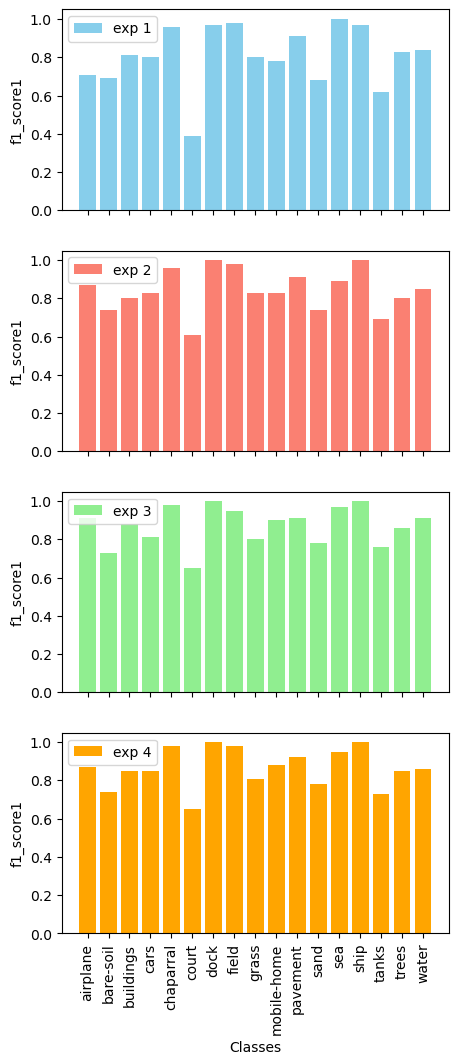

In [72]:
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(5, 12))
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']
# 绘制柱状图
for ind, val in enumerate(f1):
    f1_dict = dict(zip(full_dataset_te.class_names, val))
    axs[ind].bar(list(f1_dict.keys()), list(f1_dict.values()), color=colors[ind], label=f"exp {ind+1}")

    axs[ind].set_xlabel("Classes")
    axs[ind].set_ylabel("f1_score1")
    axs[ind].legend()
for ax in axs:
    ax.label_outer()
plt.xticks(rotation=90)
plt.show()

In [64]:
score1 = {
    "overall_acc": 0.4023809523809524,
    "f1_micro": 0.8186646433990895,
    "f1_macro": 0.8080345210017872,
    "mAP_micro": 0.7173680285623508,
    "mAP_macro": 0.73430816161051
}

score2 = {
    "overall_acc": 0.42857142857142855,
    "f1_micro": 0.8341555977229601,
    "f1_macro": 0.8429539994670496,
    "mAP_micro": 0.7402997201114841,
    "mAP_macro": 0.7744065396348563
}

score3 = {
    "overall_acc": 0.4023809523809524,
    "f1_micro": 0.8186646433990895,
    "f1_macro": 0.8080345210017872,
    "mAP_micro": 0.7173680285623508,
    "mAP_macro": 0.73430816161051
}

score4 = {
    "overall_acc": 0.45714285714285713,
    "f1_micro": 0.85258076494641566,
    "f1_macro": 0.8647708577173329,
    "mAP_micro": 0.7629728657499423,
    "mAP_macro": 0.7997387482268845
}

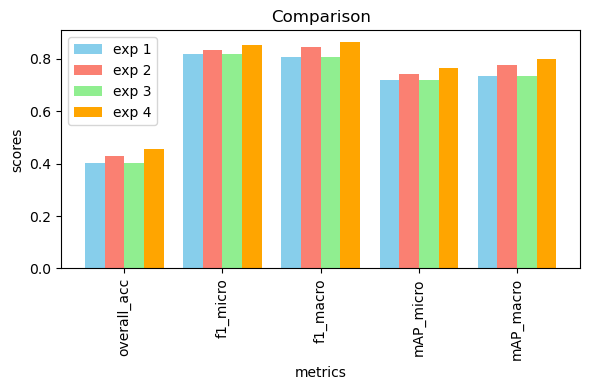

In [68]:
scores = [score1, score2, score3, score4]
labels = list(score1.keys())
n_groups = len(labels)

data = [[score[label] for label in labels] for score in scores]
bar_width = 0.2
index = np.arange(n_groups)

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']
for i, (color, dataset) in enumerate(zip(colors, data)):
    plt.bar(index + i * bar_width, dataset, bar_width, label=f'exp {i+1}', color=color)

plt.xlabel('metrics')
plt.ylabel('scores')
plt.title('Comparison')
plt.xticks(index + bar_width * 1.5, labels, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()